<a href="https://colab.research.google.com/github/AilingLiu/Growth_Analysis/blob/master/Conversion_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

The data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

In [22]:
url = 'https://github.com/AilingLiu/Growth_Analysis/blob/master/Data/bank-additional-full.csv?raw=true'

marketing = pd.read_csv(url, sep=';')
marketing.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

Here, we will be defining the customer that subscribe to the bank product as our conversion target. The column y has a binary categorical value to indicate if customer proceed the subscription or not.

In [23]:
marketing['conversion'] = np.where(marketing['y']=='yes', 1, 0)
marketing.iloc[:, -2].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [24]:
marketing.iloc[:, -2].value_counts(normalize=True).round(2)

no     0.89
yes    0.11
Name: y, dtype: float64

There are 4640 out of 36548 customers have been converted, accouting for 11% of conversion rate. Let's combine a few more independent variables to see how this rate can be affected. We will select `marital`, `age` to see the conversion rate on each level. To make the manipulation easier, we will convert the string values into binary numerical values.

Text(0, 0.5, 'conversion rate')

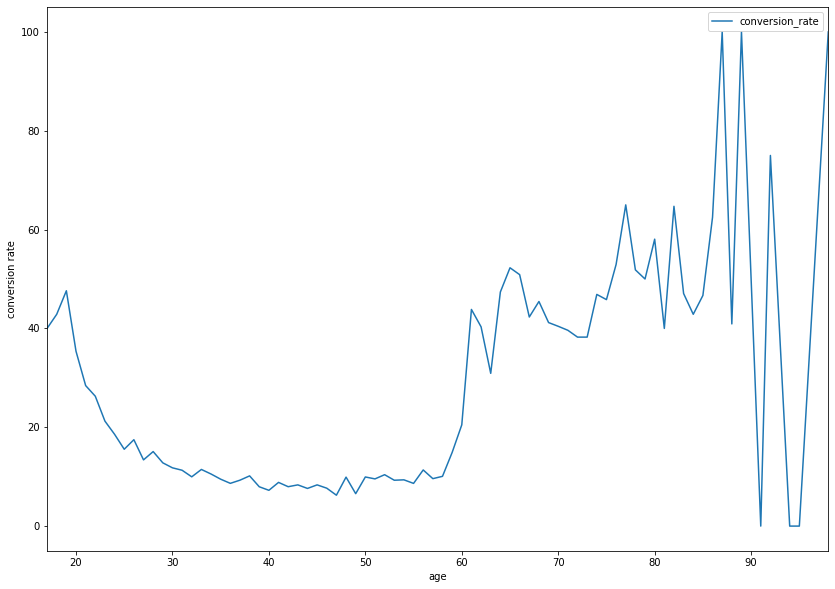

In [21]:
conversion_by_age = (marketing.groupby(['age'])['conversion'].mean().to_frame('conversion_rate')*100).round(2)
conversion_by_age.plot(kind='line', figsize=(14, 10))
plt.ylabel('conversion rate')

Since it's quite zigzaging especially at the higher end, we can bucket the age into cutomized range.

*  [, 20]
*  [21, 40]
*  [41, 60]
*  [61, 80]
*  [81, )

Text(0, 0.5, 'conversion rate')

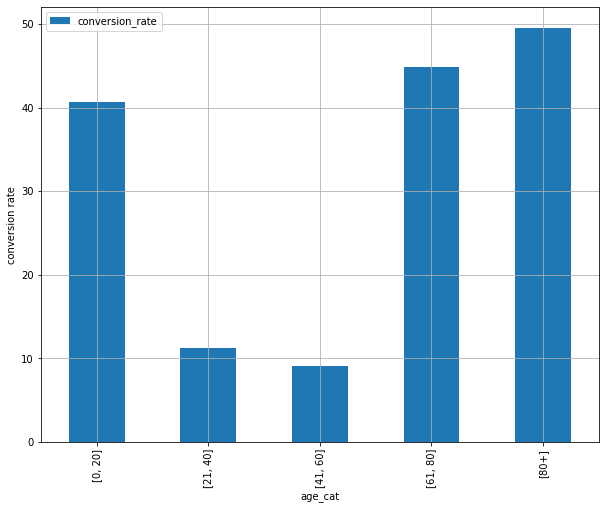

In [25]:
marketing['age_cat'] = pd.cut(marketing['age'], bins=[0, 20, 40, 60, 80, float('inf')], right=True, labels=['[0, 20]', '[21, 40]', '[41, 60]', '[61, 80]', '[80+]'])
conversion_by_age_group = (marketing.groupby(['age_cat'])['conversion'].mean().to_frame('conversion_rate')*100).round(2)
conversion_by_age_group.plot(kind='bar', figsize=(10, 8), grid=True)
plt.ylabel('conversion rate')


conversion rate by marriage

In [33]:
conversion_by_marriage = pd.pivot_table(marketing, values='y', index='marital', columns='conversion', aggfunc=len)
conversion_by_marriage.columns = ['Not_Converted', 'Converted']
conversion_by_marriage

,Not_Converted,Converted
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


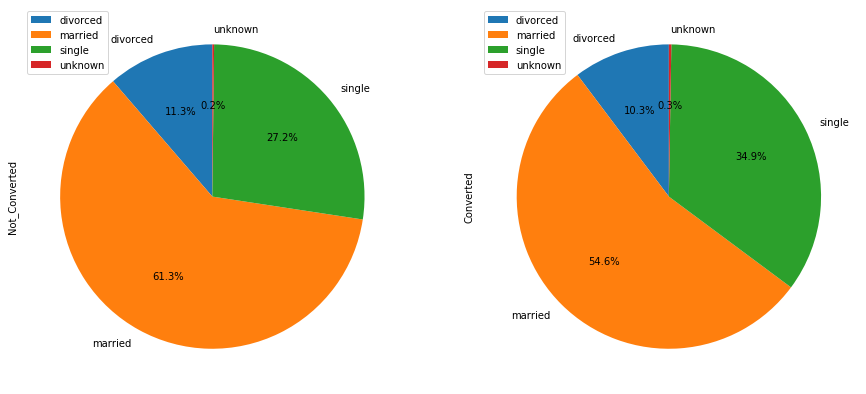

In [35]:
conversion_by_marriage.plot(
    kind='pie',
    figsize=(15, 7),
    startangle=90,
    subplots=True,
    autopct='%0.1f%%'
)

plt.show()

Here, the marriage group is the largest group in both converted and not converted status, following by single group. With pie plot, we can see the similarities and differences from both converted and not converted status.

In [0]:
a1 = marketing.groupby(['age_cat', 'marital'])['conversion'].sum().unstack().fillna(0)
a2 = marketing['age_cat'].value_counts()

age_marital_conversion = a1.divide(a2, axis=0)
age_marital_conversion.insert(loc=0, column='Total', value=a2)


In [62]:
age_marital_conversion.round(2)

marital,Total,divorced,married,single,unknown
"[0, 20]",140,0.00,0.00,0.41,0.0
"[21, 40]",23628,0.01,0.05,0.06,0.0
"[41, 60]",16510,0.01,0.07,0.01,0.0
"[61, 80]",791,0.07,0.37,0.01,0.0
[80+],119,0.26,0.22,0.02,0.0


In the first group, we have 140 customers under 20, and 41% of them have been converted. What's more, all these customers are single.

The second highest conversion rate is 37% from the marriaged group of people between 61 to 80 years old.

We can conduct a two way anova test to check if these proportions from different groups are significant, followed by a post-hoc test to check specific group differences.

Alternatively, we can construct logistic regression, to check which parameter is significant and the effects to conversion rate.

In [70]:
marketing['conversion'] = marketing['conversion'].astype('int')
model = smf.logit(formula='conversion~C(age_cat)+C(marital)', data=marketing).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.340372
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41180
Method:                           MLE   Df Model:                            7
Date:                Sun, 23 Feb 2020   Pseudo R-squ.:                 0.03311
Time:                        17:18:40   Log-Likelihood:                -14019.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                4.734e-203
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.8036      0.182     -4.414      0.000      -1.160      

The model summary shows the coefficients, standard error, the associated z-score, and the 95% confidence intervals. We interpret the results as follows, the overall model is significant indicated by a LLR p-value < 0.05 (4.734e-203) which allows us to look at the rest of the results. Except marital status in arried and unknown are not significant, all other independent variables have a significant effect on the log odds of conversion as indicated by individual P values < 0.05.

> age group
<br>Since group [0, 20] was dropped from the analysis, it is the comparison group and plays an important role in interpreting the other categories. For example, if a customer from [21, 40] age group compared to a customer from [0, 20] age group, there is a -1.4654 decrease in the log odds of conversion; if a customer from [41, 60] group compared to a [0, 20] group, there is a -1.5625 decrease in the log odds of conversion

>marital
<br>marital group uses 'divorce' group as reference group. Each other group has a higher log odds of conversion in comparison.

For easier interpretation, we can convert the log odds to probabilities of convertion.


In [83]:
coefs = pd.DataFrame(np.exp(model.params), columns=['coef.%'])
coefs/(1+coefs)

,coef.%
Intercept,0.309257
"C(age_cat)[T.[21, 40]]",0.187665
"C(age_cat)[T.[41, 60]]",0.173286
"C(age_cat)[T.[61, 80]]",0.637523
C(age_cat)[T.[80+]],0.681697
C(marital)[T.married],0.505400
C(marital)[T.single],0.606013
C(marital)[T.unknown],0.618794


Still interpreting the results in comparison to the group that was dropped. Customers from [21, 40] compared to customer from [0, 20] are 18.8% as likely to be converted; customers from [61+] compared to [0, 20] are over 63% as likely to be converted.

For the marriage status, compared to 'devorce' status, all other marriage status are over half likely to get converted.

Obviously, with only two categorical variables are not likely to get the best model. The `Pseudo R-squ.` at 0.03311 is not explaning much of the data. We can select more indepdent variables to check if it will improve the model.

In [85]:
model2 = smf.logit(formula='conversion~age+pdays+euribor3m+C(education)+C(marital)', data=marketing).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.293006
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             conversion   No. Observations:                41188
Model:                          Logit   Df Residuals:                    41174
Method:                           MLE   Df Model:                           13
Date:                Sun, 23 Feb 2020   Pseudo R-squ.:                  0.1677
Time:                        21:11:18   Log-Likelihood:                -12068.
converged:                       True   LL-Null:                       -14499.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.2959      0.132 

The model with LLR p-value less than 0.05 indicates the model is statistical significant. From the coef of each paramters, education with basic level are negatively correlated with log odds, the same as pdays, and euribor3m. Other parameters are positively correlated to log odds. Few categorical variables levels are not significant with p value greater than 0.05, while the three numerical variables are all significant. We also see the R-squ has improved greatly from 0.03 to 0.168 by adding these few parameters. For next step, we can consider to remove the non significant parameters, and add more new parameters to check if the model improves and have clear explanation to the response variable.